In [1]:
import pandas as pd

creditcard_data = pd.read_csv('creditcard.csv', index_col=0)
print(creditcard_data.info())
print('\n')
pd.options.display.max_columns = len(creditcard_data)
print(creditcard_data.head(3))

<class 'pandas.core.frame.DataFrame'>
Index: 284807 entries, 0.0 to 172792.0
Data columns (total 30 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V1      284807 non-null  float64
 1   V2      284807 non-null  float64
 2   V3      284807 non-null  float64
 3   V4      284807 non-null  float64
 4   V5      284807 non-null  float64
 5   V6      284807 non-null  float64
 6   V7      284807 non-null  float64
 7   V8      284807 non-null  float64
 8   V9      284807 non-null  float64
 9   V10     284807 non-null  float64
 10  V11     284807 non-null  float64
 11  V12     284807 non-null  float64
 12  V13     284807 non-null  float64
 13  V14     284807 non-null  float64
 14  V15     284807 non-null  float64
 15  V16     284807 non-null  float64
 16  V17     284807 non-null  float64
 17  V18     284807 non-null  float64
 18  V19     284807 non-null  float64
 19  V20     284807 non-null  float64
 20  V21     284807 non-null  float64
 21  V22     284

In [2]:
round(creditcard_data['Class'].value_counts()*100/len(creditcard_data)).convert_dtypes()

Class
0    100
1      0
Name: count, dtype: Int64

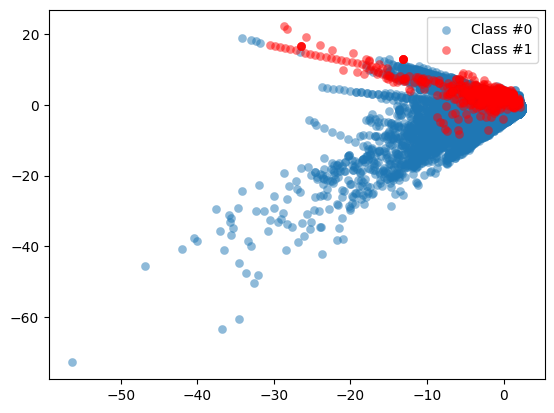

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def prep_data(df):
    X = df.iloc[:, 0:28]
    X = np.array(X).astype(float)
    y = df.iloc[:, 29]
    y = np.array(y).astype(float)
    return X, y

def plot_data(X, y):
    plt.scatter(X[y==0, 0], X[y==0, 1], label='Class #0', alpha=0.5, linewidth=0.15)
    plt.scatter(X[y==1, 0], X[y==1, 1], label='Class #1', alpha=0.5, linewidth=0.15, c='r')
    plt.legend()
    return plt.show()

X, y = prep_data(creditcard_data)

plot_data(X, y)

In [4]:
# The idea is to define threshold values based on common statistics, 
# often on the mean values of observations, and use those thresholds 
# on our features to detect fraud.
print(creditcard_data.groupby('Class').mean().round(3)[['V1', 'V3']])

          V1     V3
Class              
0      0.008  0.012
1     -4.772 -7.033


In [5]:
creditcard_data['flag_as_fraud'] = np.where(np.logical_and(creditcard_data['V1']<-3, creditcard_data['V3']<-5), 1, 0)
print(pd.crosstab(creditcard_data['Class'], creditcard_data['flag_as_fraud'], rownames=['Actual Fraud'], colnames=['Flagged Fraud']))

Flagged Fraud       0     1
Actual Fraud               
0              283089  1226
1                 322   170


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

lr = LogisticRegression()
lr.fit(X_train, y_train)
predictions = lr.predict(X_test)
print(pd.crosstab(y_test, predictions, rownames=['Actual Fraud'], colnames=['Flagged Fraud']))

Flagged Fraud    0.0  1.0
Actual Fraud             
0.0            85285   11
1.0               56   91


In [7]:
import pickle

# Save the Logistic Regression model to a file
with open('logistic_regression_model.pkl', 'wb') as file:
    pickle.dump(lr, file)

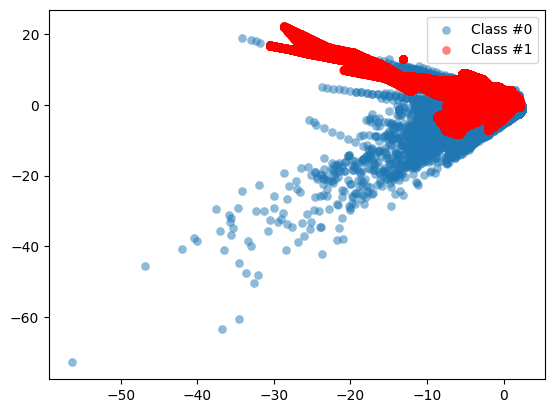

In [8]:
from imblearn.over_sampling import SMOTE

method = SMOTE()
X_resampled, y_resampled = method.fit_resample(X, y)
plot_data(X_resampled, y_resampled)

Original set:
0.0    284315
1.0       492
Name: count, dtype: int64

SMOTE:
0.0    284315
1.0    284315
Name: count, dtype: int64



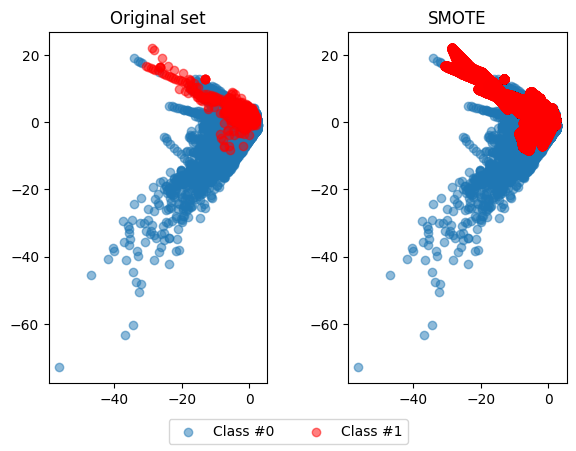

In [9]:
def compare_plot(X, y, X_resampled, y_resampled, method):
    f, (ax1, ax2) = plt.subplots(1, 2)
    c0 = ax1.scatter(X[y==0, 0], X[y==0, 1], label='Class #0',alpha=0.5)
    c1 = ax1.scatter(X[y==1, 0], X[y==1, 1], label='Class #1',alpha=0.5, c='r')
    ax1.set_title('Original set')
    ax2.scatter(X_resampled[y_resampled==0, 0], X_resampled[y_resampled==0, 1], label='Class #0', alpha=.5)
    ax2.scatter(X_resampled[y_resampled==1, 0], X_resampled[y_resampled==1, 1], label='Class #1', alpha=.5,c='r')
    ax2.set_title(method)
    plt.figlegend((c0, c1), ('Class #0', 'Class #1'), loc='lower center', ncol=2, labelspacing=0.)
    plt.tight_layout(pad=3)
    return plt.show()

print(f'Original set:\n'
      f'{pd.value_counts(pd.Series(y))}\n\n'
      f'SMOTE:\n'
      f'{pd.value_counts(pd.Series(y_resampled))}\n')

compare_plot(X, y, X_resampled, y_resampled, method='SMOTE')

In [10]:
from imblearn.pipeline import Pipeline

# Defining which resampling method and which ML model to use in the pipeline
resampling = SMOTE()
lr = LogisticRegression()

pipeline = Pipeline([('SMOTE', resampling), ('Logistic Regression', lr)])
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
print(pd.crosstab(y_test, predictions, rownames=['Actual Fraud'], colnames=['Flagged Fraud']))

Flagged Fraud    0.0   1.0
Actual Fraud              
0.0            83201  2095
1.0               12   135


In [11]:
import pickle

# Save the pipeline to a file
with open('pipeline.pkl', 'wb') as file:
    pickle.dump(pipeline, file)

In [2]:
# Define the task to load the model
import pickle
def load_model(model_file):
    with open(model_file, 'rb') as file:
        model = pickle.load(file)
    return model
model_file = "pipeline.pkl"
model = load_model(model_file)

In [33]:
# data = ['53393', '-0.685503301464494', '0.371116339137508', '2.29620027950088', '-1.15260348115469', '0.192346504967105', '0.637572531419258', '0.442085940523061', '0.0934448904279641', '0.119431152636075', '-0.726568742973774', '0.0243091825691235', '0.386245895227031', '0.335422310493073', '-0.574829359353251', '-0.499516519401832', '0.915083311376495', '-1.27973567595051', '0.721290095958689', '0.211990637474372', '0.137577927012717', '-0.0696200542440359', '-0.0611511493933153', '-0.387846437076485', '-0.794244294328955', '0.294316070747869', '0.562697253535863', '-0.172670753731128', '-0.179019072091509', '37.34', '0']
# data.reshape(array.reshape(1, -1))
# model.predict(data[1:29])
import pandas as pd
df1 = pd.read_csv("..\data_generation\source1.csv", header=None)
df1

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,70563,-0.677664,-0.483585,1.895252,-1.780627,-0.942811,0.198937,-0.025048,0.259071,-1.206951,...,0.652415,1.525034,0.115389,0.043183,-0.293916,-0.248868,0.109761,0.142343,134.99,0


In [36]:
processed_data = df1.iloc[:, 1:29]
actual_prediction = df1.iloc[:,30:31]
id = df1.iloc[:,0:1]
id

,0
0,70563


In [17]:
model.predict(df1.iloc[:,1:29])

array([0.])

In [20]:
def process_data(data):
    processed_data = data.iloc[:, 1:29]
    actual_prediction = data.iloc[:, 30:31]
    return processed_data

prediction = model.predict(process_data(df1))

In [30]:
pred = pd. DataFrame(prediction, columns=['Prediction'])
pred

,Prediction
0,0.0


In [32]:
df3 = pd.concat([processed_data, actual_prediction,pred], axis=1)
df3

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,30,Prediction
0,-0.677664,-0.483585,1.895252,-1.780627,-0.942811,0.198937,-0.025048,0.259071,-1.206951,-0.021127,...,0.652415,1.525034,0.115389,0.043183,-0.293916,-0.248868,0.109761,0.142343,0,0.0
